# Analyzing Football Player Scores with Sorare Data

## Preparing Data

### Import libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px


from requests import get as get
from requests import post as post
import json
import bcrypt

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.decomposition import PCA


### API Authentication

In [3]:
email = "maite.marzoratti@gmail.com"

r = get(f'https://api.sorare.com/api/v1/users/{email}')
response = json.loads(r.content)
cookies={"_sorare_session_id":r.cookies['_sorare_session_id']}
# get salt and hash with password
salt = response['salt'].encode('utf8')
pwrd = "s.r6yZBkaxbbX:7".encode('utf8')
hashed = bcrypt.hashpw(pwrd, salt).decode('utf8')
csrf = r.headers["CSRF-TOKEN"]

headers = {
    "x-csrf-token": csrf
}

# login
url = 'https://api.sorare.com/graphql'
login_query = """
mutation SignInMutation($input: signInInput!) {
  signIn(input: $input) {
    currentUser {
      slug
      __typename
    }
    otpSessionChallenge
    errors {
      path
      message
      __typename
    }
    __typename
  }
}
"""

variables = {
  "input": {
    "email": email,
    "password": hashed
  }
}

p = post(url, json={'query': login_query, 'OperationName': 'SignInMutation', 'variables': variables}, 
        headers=headers,cookies=cookies)


In [4]:
# # Write your query or mutation here
# player_query="""
# query {
#   player(slug: "rodrigo-javier-de-paul") {
#     id
#     displayName
#     activeClub {
#       name
#       slug
#     }
#     activeClub {
#       name
#     }
#     status {
#       lastFiveSo5AverageScore
#       lastFifteenSo5AverageScore
#     }
#   }
# }"""

# t=post(url, json={'query': player_query, 'OperationName': 'SignInMutation', 'variables': variables}, 
#         headers=headers,cookies=cookies)
# t1=t.json()['data']['player']

# pd.json_normalize(t1)

### Sorare API Query

In [6]:
laliga_query="""
query {
  competition(slug:"primera-division-es") {
    clubs {
      nodes {
        name
        slug
        activePlayers {
          nodes {
            displayName
            slug
            status {
              lastFiveSo5Appearances
              lastFiveSo5AverageScore
              lastFifteenSo5Appearances
              lastFifteenSo5AverageScore
              playingStatus
            }
            lastClub {
              name
              activeCompetitions {
                name
              }
            }
            allSo5Scores (first:5) {
              nodes {
                position
                score
                detailedScore {
                  category
                  points
                  stat
                  statValue
                  totalScore
                }
              }
            }
          }
        }
      }
    }
  }
}"""

laliga_r=post(url, json={'query': laliga_query, 'OperationName': 'SignInMutation', 'variables': variables}, 
        headers=headers,cookies=cookies)


In [7]:
laliga_data=laliga_r.json()['data']['competition']['clubs']['nodes']
df_laliga=pd.json_normalize(laliga_data)
df_laliga.head()

,name,slug,activePlayers.nodes
0,CA Osasuna,osasuna-pamplona-irunea,"[{'displayName': 'Arrasate', 'slug': 'jagoba-a..."
1,Real Madrid CF,real-madrid-madrid,"[{'displayName': 'Rodrygo', 'slug': 'rodrygo-s..."
2,Granada CF,granada-granada,"[{'displayName': 'Luis Suárez', 'slug': 'luis-..."
3,Cádiz CF,cadiz-cadiz,"[{'displayName': 'Álex', 'slug': 'alejandro-fe..."
4,Sevilla FC,sevilla-sevilla-1890,"[{'displayName': 'Antonio Zarzana', 'slug': 'a..."


In [8]:
df_laliga.shape

(20, 3)

### Response Clean Up

Expand players

In [382]:
laliga_data=laliga_r.json()['data']['competition']['clubs']['nodes']
df_laliga=pd.json_normalize(laliga_data)
df_laliga_players=df_laliga.explode(column='activePlayers.nodes').reset_index(drop=True)
A=pd.json_normalize(df_laliga_players['activePlayers.nodes'])
df_laliga_players=df_laliga_players.drop(columns='activePlayers.nodes').join(A,how='left',rsuffix='_player',lsuffix='_club')
df_laliga_players.head()


,name,slug_club,displayName,slug_player,status.lastFiveSo5Appearances,status.lastFiveSo5AverageScore,status.lastFifteenSo5Appearances,status.lastFifteenSo5AverageScore,status.playingStatus,lastClub.name,lastClub.activeCompetitions,allSo5Scores.nodes
0,CA Osasuna,osasuna-pamplona-irunea,Arrasate,jagoba-arrasate-elustondo,0,0.000000,0,0.000000,not_playing,CA Osasuna,"[{'name': 'Primera División'}, {'name': 'Copa ...",[]
1,CA Osasuna,osasuna-pamplona-irunea,Kike,enrique-garcia-martinez,3,48.466667,13,41.015385,starter,CA Osasuna,"[{'name': 'Primera División'}, {'name': 'Copa ...","[{'position': 'Forward', 'score': 68.6, 'detai..."
2,CA Osasuna,osasuna-pamplona-irunea,Sergio Herrera,sergio-herrera-piron,5,41.240000,14,46.964286,starter,CA Osasuna,"[{'name': 'Primera División'}, {'name': 'Copa ...","[{'position': 'Goalkeeper', 'score': 20.2, 'de..."
3,CA Osasuna,osasuna-pamplona-irunea,Roberto Torres,roberto-torres-morales,4,26.825000,11,39.018182,substitute,CA Osasuna,"[{'name': 'Primera División'}, {'name': 'Copa ...","[{'position': 'Midfielder', 'score': 28.3, 'de..."
4,CA Osasuna,osasuna-pamplona-irunea,Jonás Ramalho,jonas-ramalho-chimeno,0,0.000000,0,0.000000,not_playing,CA Osasuna,"[{'name': 'Primera División'}, {'name': 'Copa ...","[{'position': 'Defender', 'score': None, 'deta..."


In [416]:
df_laliga_players.shape

(688, 12)

In [383]:
pd.json_normalize(df_laliga_players[df_laliga_players.slug_player=='luka-modric']['allSo5Scores.nodes'])

,0,1,2,3,4
0,"{'position': 'Midfielder', 'score': 56.1, 'det...","{'position': 'Midfielder', 'score': None, 'det...","{'position': 'Midfielder', 'score': None, 'det...","{'position': 'Midfielder', 'score': 61.2, 'det...","{'position': 'Midfielder', 'score': 50.1, 'det..."


Expand player scores (all)

In [384]:
a=df_laliga_players.explode('allSo5Scores.nodes').reset_index(drop=True)
a[a.slug_player=='luka-modric']

,name,slug_club,displayName,slug_player,status.lastFiveSo5Appearances,status.lastFiveSo5AverageScore,status.lastFifteenSo5Appearances,status.lastFifteenSo5AverageScore,status.playingStatus,lastClub.name,lastClub.activeCompetitions,allSo5Scores.nodes
276,Real Madrid CF,real-madrid-madrid,Luka Modrić,luka-modric,3,55.8,12,64.425,starter,Real Madrid CF,"[{'name': 'UEFA Champions League'}, {'name': '...","{'position': 'Midfielder', 'score': 56.1, 'det..."
277,Real Madrid CF,real-madrid-madrid,Luka Modrić,luka-modric,3,55.8,12,64.425,starter,Real Madrid CF,"[{'name': 'UEFA Champions League'}, {'name': '...","{'position': 'Midfielder', 'score': None, 'det..."
278,Real Madrid CF,real-madrid-madrid,Luka Modrić,luka-modric,3,55.8,12,64.425,starter,Real Madrid CF,"[{'name': 'UEFA Champions League'}, {'name': '...","{'position': 'Midfielder', 'score': None, 'det..."
279,Real Madrid CF,real-madrid-madrid,Luka Modrić,luka-modric,3,55.8,12,64.425,starter,Real Madrid CF,"[{'name': 'UEFA Champions League'}, {'name': '...","{'position': 'Midfielder', 'score': 61.2, 'det..."
280,Real Madrid CF,real-madrid-madrid,Luka Modrić,luka-modric,3,55.8,12,64.425,starter,Real Madrid CF,"[{'name': 'UEFA Champions League'}, {'name': '...","{'position': 'Midfielder', 'score': 50.1, 'det..."


In [385]:
df_laliga_player_scores=df_laliga_players.explode('allSo5Scores.nodes').reset_index(drop=True)
pd.json_normalize(df_laliga_player_scores['allSo5Scores.nodes'])

,position,score,detailedScore
0,NaN,NaN,NaN
1,Forward,68.6,"[{'category': 'UNKNOWN', 'points': 0.0, 'stat'..."
2,Forward,NaN,"[{'category': 'UNKNOWN', 'points': 0.0, 'stat'..."
3,Forward,33.2,"[{'category': 'UNKNOWN', 'points': 0.0, 'stat'..."
4,Forward,0.0,"[{'category': 'UNKNOWN', 'points': 0.0, 'stat'..."
...,...,...,...
3246,Midfielder,50.8,"[{'category': 'UNKNOWN', 'points': 0.0, 'stat'..."
3247,Midfielder,76.1,"[{'category': 'UNKNOWN', 'points': 0.0, 'stat'..."
3248,Midfielder,89.5,"[{'category': 'UNKNOWN', 'points': 0.0, 'stat'..."
3249,Midfielder,34.5,"[{'category': 'UNKNOWN', 'points': 0.0, 'stat'..."


In [386]:
df_laliga_player_scores=df_laliga_players.explode('allSo5Scores.nodes').reset_index(drop=True)
B=pd.json_normalize(df_laliga_player_scores['allSo5Scores.nodes'])
df_laliga_player_scores=df_laliga_player_scores.drop(columns='allSo5Scores.nodes').join(B,how='left')
df_laliga_player_scores.head()

,name,slug_club,displayName,slug_player,status.lastFiveSo5Appearances,status.lastFiveSo5AverageScore,status.lastFifteenSo5Appearances,status.lastFifteenSo5AverageScore,status.playingStatus,lastClub.name,lastClub.activeCompetitions,position,score,detailedScore
0,CA Osasuna,osasuna-pamplona-irunea,Arrasate,jagoba-arrasate-elustondo,0,0.000000,0,0.000000,not_playing,CA Osasuna,"[{'name': 'Primera División'}, {'name': 'Copa ...",NaN,NaN,NaN
1,CA Osasuna,osasuna-pamplona-irunea,Kike,enrique-garcia-martinez,3,48.466667,13,41.015385,starter,CA Osasuna,"[{'name': 'Primera División'}, {'name': 'Copa ...",Forward,68.6,"[{'category': 'UNKNOWN', 'points': 0.0, 'stat'..."
2,CA Osasuna,osasuna-pamplona-irunea,Kike,enrique-garcia-martinez,3,48.466667,13,41.015385,starter,CA Osasuna,"[{'name': 'Primera División'}, {'name': 'Copa ...",Forward,NaN,"[{'category': 'UNKNOWN', 'points': 0.0, 'stat'..."
3,CA Osasuna,osasuna-pamplona-irunea,Kike,enrique-garcia-martinez,3,48.466667,13,41.015385,starter,CA Osasuna,"[{'name': 'Primera División'}, {'name': 'Copa ...",Forward,33.2,"[{'category': 'UNKNOWN', 'points': 0.0, 'stat'..."
4,CA Osasuna,osasuna-pamplona-irunea,Kike,enrique-garcia-martinez,3,48.466667,13,41.015385,starter,CA Osasuna,"[{'name': 'Primera División'}, {'name': 'Copa ...",Forward,0.0,"[{'category': 'UNKNOWN', 'points': 0.0, 'stat'..."


In [387]:
df_laliga_player_scores[df_laliga_player_scores.slug_player=='luka-modric'][['slug_player','position','score']]

,slug_player,position,score
276,luka-modric,Midfielder,56.1
277,luka-modric,Midfielder,NaN
278,luka-modric,Midfielder,NaN
279,luka-modric,Midfielder,61.2
280,luka-modric,Midfielder,50.1


Add detailed score

https://draftgym.com/sorare-new-scoring-system-explained

In [388]:
df_laliga_player_scores['detailedScore']

0                                                     NaN
1       [{'category': 'UNKNOWN', 'points': 0.0, 'stat'...
2       [{'category': 'UNKNOWN', 'points': 0.0, 'stat'...
3       [{'category': 'UNKNOWN', 'points': 0.0, 'stat'...
4       [{'category': 'UNKNOWN', 'points': 0.0, 'stat'...
                              ...                        
3246    [{'category': 'UNKNOWN', 'points': 0.0, 'stat'...
3247    [{'category': 'UNKNOWN', 'points': 0.0, 'stat'...
3248    [{'category': 'UNKNOWN', 'points': 0.0, 'stat'...
3249    [{'category': 'UNKNOWN', 'points': 0.0, 'stat'...
3250    [{'category': 'UNKNOWN', 'points': 0.0, 'stat'...
Name: detailedScore, Length: 3251, dtype: object

In [389]:
df_laliga_player_scores['detailedScore'].iloc[8][8]

{'category': 'PASSING',
 'points': -0.2,
 'stat': 'missed_pass',
 'statValue': 13.0,
 'totalScore': -2.6}

In [390]:
total=0
for i in range(len(df_laliga_player_scores.iloc[2]['detailedScore'])):
    total=total+df_laliga_player_scores.iloc[2]['detailedScore'][i]['totalScore']
total

25.0

In [391]:
#detailed stats to columns
df_stats=pd.DataFrame()

for j_player in range(df_laliga_player_scores.shape[0]):
    if df_laliga_player_scores.iloc[j_player]['detailedScore']==df_laliga_player_scores.iloc[j_player]['detailedScore']:
        df_stat_i=pd.DataFrame()
        for i in range(len(df_laliga_player_scores.iloc[j_player]['detailedScore'])):
            index=df_laliga_player_scores.index[j_player]
            stat_name=df_laliga_player_scores.iloc[j_player]['detailedScore'][i]['stat']
            stat_value=df_laliga_player_scores.iloc[j_player]['detailedScore'][i]['statValue']
            df_stat_i=pd.concat([df_stat_i,pd.DataFrame(index=[index],columns=[stat_name],data=[stat_value])],axis=1)
        df_stats=df_stats.append(df_stat_i)
df_stats.head(10)

,level_score,mins_played,yellow_card,was_fouled,error_lead_to_shot,double_double,triple_double,triple_triple,poss_lost_ctrl,duel_lost,...,effective_clearance,long_pass_own_to_opp_success,goal_assist,red_card,assist_penalty_won,error_lead_to_goal,own_goals,clearance_off_line,penalty_conceded,penalty_save
1,0.0,90.0,1.0,1.0,0.0,0.0,0.0,0.0,17.0,8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,68.0,0.0,1.0,0.0,0.0,0.0,0.0,5.0,9.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.0,90.0,0.0,5.0,0.0,0.0,0.0,0.0,16.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0.0,90.0,1.0,NaN,0.0,NaN,NaN,NaN,10.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0.0,90.0,0.0,NaN,0.0,NaN,NaN,NaN,22.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0.0,90.0,0.0,NaN,0.0,NaN,NaN,NaN,13.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0.0,90.0,0.0,NaN,0.0,NaN,NaN,NaN,17.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,0.0,90.0,0.0,NaN,0.0,NaN,NaN,NaN,8.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [392]:
df_laliga_player_scores_detailed=df_laliga_player_scores.join(df_stats,how='left')
df_laliga_player_scores_detailed.drop(columns='detailedScore',inplace=True)
df_laliga_player_scores_detailed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3251 entries, 0 to 3250
Data columns (total 65 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   name                               3251 non-null   object 
 1   slug_club                          3251 non-null   object 
 2   displayName                        3251 non-null   object 
 3   slug_player                        3251 non-null   object 
 4   status.lastFiveSo5Appearances      3251 non-null   int64  
 5   status.lastFiveSo5AverageScore     3251 non-null   float64
 6   status.lastFifteenSo5Appearances   3251 non-null   int64  
 7   status.lastFifteenSo5AverageScore  3251 non-null   float64
 8   status.playingStatus               3243 non-null   object 
 9   lastClub.name                      3251 non-null   object 
 10  lastClub.activeCompetitions        3251 non-null   object 
 11  position                           3229 non-null   objec

In [393]:
df_laliga_player_scores_detailed.loc[:,df_laliga_player_scores_detailed.dtypes=='float64']=df_laliga_player_scores_detailed.loc[:,df_laliga_player_scores_detailed.dtypes=='float64'].fillna(0)

In [415]:
df_laliga_player_scores_detailed[df_laliga_player_scores_detailed.slug_player=='karim-benzema'].iloc[:,12:]

,score,level_score,mins_played,yellow_card,was_fouled,error_lead_to_shot,double_double,triple_double,triple_triple,poss_lost_ctrl,...,effective_clearance,long_pass_own_to_opp_success,goal_assist,red_card,assist_penalty_won,error_lead_to_goal,own_goals,clearance_off_line,penalty_conceded,penalty_save
256,45.0,0.0,90.0,0.0,2.0,0.0,0.0,0.0,0.0,18.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
257,84.3,0.0,89.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
258,58.0,0.0,90.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
259,65.7,0.0,45.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [395]:
df_laliga_player_scores_detailed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3251 entries, 0 to 3250
Data columns (total 65 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   name                               3251 non-null   object 
 1   slug_club                          3251 non-null   object 
 2   displayName                        3251 non-null   object 
 3   slug_player                        3251 non-null   object 
 4   status.lastFiveSo5Appearances      3251 non-null   int64  
 5   status.lastFiveSo5AverageScore     3251 non-null   float64
 6   status.lastFifteenSo5Appearances   3251 non-null   int64  
 7   status.lastFifteenSo5AverageScore  3251 non-null   float64
 8   status.playingStatus               3243 non-null   object 
 9   lastClub.name                      3251 non-null   object 
 10  lastClub.activeCompetitions        3251 non-null   object 
 11  position                           3229 non-null   objec

In [396]:
df_laliga_player_scores_detailed.dtypes[12:]

score                            float64
level_score                      float64
mins_played                      float64
yellow_card                      float64
was_fouled                       float64
error_lead_to_shot               float64
double_double                    float64
triple_double                    float64
triple_triple                    float64
poss_lost_ctrl                   float64
duel_lost                        float64
duel_won                         float64
big_chance_created               float64
adjusted_total_att_assist        float64
accurate_pass                    float64
successful_final_third_passes    float64
ontarget_scoring_att             float64
won_contest                      float64
pen_area_entries                 float64
penalty_kick_missed              float64
big_chance_missed                float64
saves                            float64
saved_ibox                       float64
good_high_claim                  float64
punches         

In [397]:
df_laliga_player_scores_detailed[df_laliga_player_scores_detailed.slug_player=='luka-modric']['position']

276    Midfielder
277    Midfielder
278    Midfielder
279    Midfielder
280    Midfielder
Name: position, dtype: object

In [398]:
df_laliga_player_scores_detailed[['name','slug_club','displayName','slug_player','status.lastFiveSo5Appearances','level_score']].groupby(['name','slug_club','displayName','slug_player','status.lastFiveSo5Appearances','displayName'])['level_score'].mean()

name                  slug_club              displayName       slug_player                   status.lastFiveSo5Appearances  displayName     
Athletic Club Bilbao  athletic-club-bilbao   Aitor Paredes     aitor-paredes-casamichana     0                              Aitor Paredes       0.0
                                             Ander Iru         ander-iruarrizaga-diez        0                              Ander Iru           0.0
                                             Asier Villalibre  asier-villalibre-molina       0                              Asier Villalibre    0.0
                                             Balenziaga        mikel-balenziaga-oruesagasti  4                              Balenziaga          0.0
                                             Beñat Prados      benat-prados-diaz             0                              Beñat Prados        0.0
                                                                                                                       

In [399]:
df_laliga_player_scores_detailed.drop(columns=['lastClub.name','lastClub.activeCompetitions'])
df_laliga_player_scores_grouped=df_laliga_player_scores_detailed.groupby(['name','slug_club','displayName','slug_player',
'status.lastFiveSo5Appearances','status.lastFiveSo5AverageScore','status.lastFifteenSo5Appearances','status.lastFifteenSo5AverageScore',
'status.playingStatus','position']).mean().reset_index()

In [400]:
df_laliga_player_scores_detailed[df_laliga_player_scores_detailed.slug_player=='aitor-paredes-casamichana'][['mins_played','score','level_score']]

,mins_played,score,level_score
1992,0.0,0.0,0.0
1993,0.0,0.0,0.0
1994,0.0,0.0,0.0
1995,0.0,0.0,0.0
1996,0.0,0.0,0.0


In [401]:
df_laliga_player_scores_grouped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 666 entries, 0 to 665
Data columns (total 63 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   name                               666 non-null    object 
 1   slug_club                          666 non-null    object 
 2   displayName                        666 non-null    object 
 3   slug_player                        666 non-null    object 
 4   status.lastFiveSo5Appearances      666 non-null    int64  
 5   status.lastFiveSo5AverageScore     666 non-null    float64
 6   status.lastFifteenSo5Appearances   666 non-null    int64  
 7   status.lastFifteenSo5AverageScore  666 non-null    float64
 8   status.playingStatus               666 non-null    object 
 9   position                           666 non-null    object 
 10  score                              666 non-null    float64
 11  level_score                        666 non-null    float64

## Exploratory Analysis

status

In [402]:
df_laliga_player_scores_grouped['status.playingStatus'].value_counts()

not_playing    294
starter        208
substitute     122
regular         42
Name: status.playingStatus, dtype: int64

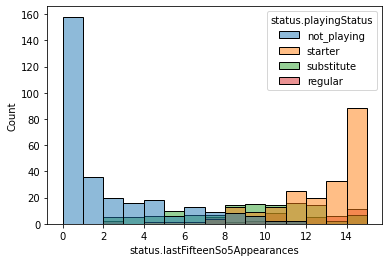

In [403]:
sns.histplot(data=df_laliga_player_scores_grouped,x='status.lastFifteenSo5Appearances',binwidth=1,hue='status.playingStatus');

In [404]:
df_laliga_player_scores_grouped['goals'].describe()

count    666.000000
mean       0.039715
std        0.128917
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.400000
Name: goals, dtype: float64

In [495]:
stat_columns=df_laliga_player_scores_grouped.columns[12:]


Stats

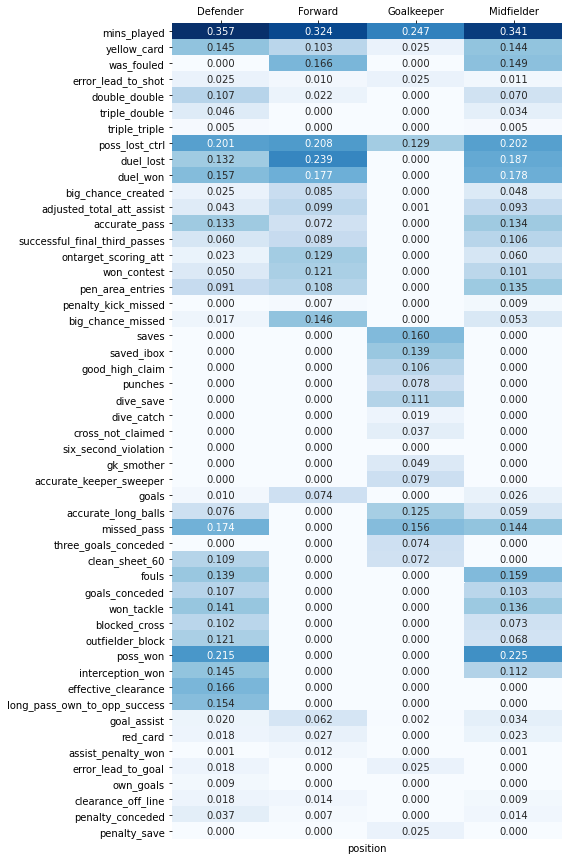

In [515]:
scaler_minmax=MinMaxScaler()
stats_scaled=scaler_minmax.fit_transform(df_laliga_player_scores_grouped[stat_columns])

df_stats_minmax=pd.DataFrame(data=stats_scaled,columns=stat_columns)
df_stats_minmax['position']=df_laliga_player_scores_grouped['position']

plt.figure(figsize=(7,15))
sns.heatmap(df_stats_minmax.groupby('position')[stat_columns].mean().T,annot=True,cbar=False,fmt='.3f',cmap='Blues')
plt.gca().xaxis.set_ticks_position('top')


## Clustering

### PCA

In [547]:
mask_starter=df_laliga_player_scores_grouped['status.playingStatus']=='starter'
mask_regular=df_laliga_player_scores_grouped['status.playingStatus']=='regular'

X=df_laliga_player_scores_grouped[mask_starter|mask_regular]
X=X.iloc[:,12:]
print(X.shape)


scaler=StandardScaler()
X_scaled=scaler.fit_transform(X)

pca_df = PCA()
pca_df.fit(X_scaled)
pca_df.explained_variance_ratio_.round(2)

(250, 51)


array([0.19, 0.14, 0.08, 0.04, 0.03, 0.03, 0.03, 0.03, 0.03, 0.02, 0.02,
       0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

In [548]:
pd.Series(pca_df.explained_variance_ratio_).cumsum()

0     0.186500
1     0.326658
2     0.405318
3     0.446423
4     0.480842
5     0.511150
6     0.540217
7     0.568328
8     0.594913
9     0.619013
10    0.642086
11    0.664675
12    0.685938
13    0.706374
14    0.726408
15    0.745876
16    0.763969
17    0.781294
18    0.797621
19    0.813498
20    0.828450
21    0.842821
22    0.856287
23    0.868721
24    0.880848
25    0.892373
26    0.903085
27    0.913252
28    0.922552
29    0.930509
30    0.938142
31    0.945077
32    0.951253
33    0.957057
34    0.962420
35    0.967654
36    0.972527
37    0.976741
38    0.980404
39    0.983310
40    0.986036
41    0.988585
42    0.990813
43    0.992927
44    0.994888
45    0.996685
46    0.998051
47    0.999003
48    0.999788
49    1.000000
50    1.000000
dtype: float64

In [549]:
pca_loadings = pd.DataFrame(pca_df.components_.T, index=X.columns).iloc[:,:10]
pca_loadings.style.background_gradient(axis=None,cmap='coolwarm')

,0,1,2,3,4,5,6,7,8,9
mins_played,0.039616,-0.107788,0.341318,-0.190207,0.214950,0.011785,0.113323,0.016491,-0.014013,-0.019429
yellow_card,-0.075934,-0.065641,0.040186,0.112032,0.152776,-0.109290,-0.150968,-0.124637,0.409833,-0.187679
was_fouled,-0.143559,0.200576,0.142504,0.164122,0.106376,0.016453,-0.046513,0.140226,-0.016858,-0.123696
error_lead_to_shot,0.056950,-0.037912,0.033624,-0.148715,-0.030854,0.183211,0.043905,0.306615,-0.264104,-0.056540
double_double,-0.078557,-0.180412,0.102885,0.031674,-0.089629,-0.019801,-0.092197,-0.199661,-0.131150,0.038907
triple_double,-0.037073,-0.123637,-0.008536,0.249276,0.098617,0.086588,0.392359,0.004867,-0.091083,0.313352
triple_triple,-0.011967,-0.041288,0.007792,0.222299,0.076369,0.074025,0.373876,0.070049,-0.009904,0.330840
poss_lost_ctrl,-0.033991,-0.002322,0.416295,-0.094915,0.150841,-0.047468,-0.085843,-0.106479,-0.126235,0.020789
duel_lost,-0.206464,0.107633,0.131418,0.007328,0.340766,-0.037146,-0.081339,-0.077649,-0.033902,-0.097424
duel_won,-0.223255,-0.037819,0.199909,0.079953,0.286056,-0.010680,-0.012501,-0.098199,-0.120227,0.005371


### Cluster

In [550]:
def Search_Kmeans(X_scaled):
    k_values=range(2,20)
    sq_distances=[] 
    sil=[]
    ch_scores=[]
    for k in k_values:
        kmeans=KMeans(n_clusters=k,n_init=10,random_state=0)
        kmeans.fit(X_scaled)
        sq_distances.append(kmeans.inertia_)
        score=silhouette_score(X_scaled,kmeans.labels_)
        sil.append(score)
        score=calinski_harabasz_score(X_scaled,kmeans.labels_)
        ch_scores.append(score)

    fig, axs = plt.subplots(1,3,figsize=(20,5))
    axs[0].set(xlabel = "Número de clusters", ylabel = "Suma Distancias Cuadráticas", title = "Inercia Score")
    axs[1].set(xlabel = "Número de clusters", ylabel = "Silhouette score", title = "Silhouette Score")
    axs[2].set(xlabel = "Número de clusters", ylabel = "Calinski-Harabasz Score", title = "Calinski-Harabasz Score")
    sns.lineplot(ax=axs[0],x=k_values,y=sq_distances,marker='o',size=30,legend=False )
    sns.lineplot(ax=axs[1],x=k_values,y=sil,marker='o',size=30,legend=False )
    sns.lineplot(ax=axs[2],x=k_values,y=ch_scores,marker='o',size=30,legend=False )
    axs[0].grid(color='gray', linewidth=1, ls='--')
    axs[1].grid(color='gray', linewidth=1, ls='--')
    axs[2].grid(color='gray', linewidth=1, ls='--')

In [551]:
X.shape

(250, 51)

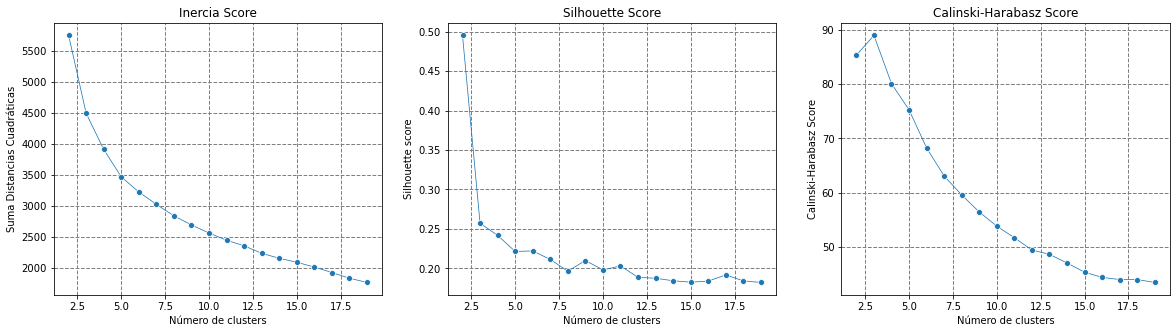

In [671]:
n_components=10
df_pca = pd.DataFrame(pca_df.transform(X_scaled)[:,:n_components], index=X.index)
df_pca.head(5)

Search_Kmeans(df_pca)

In [787]:
n_clusters=5
kmeans=KMeans(n_clusters=n_clusters,random_state=1)
kmeans.fit(df_pca)

df_output=df_laliga_player_scores_grouped.loc[X.index]
df_output['label']=kmeans.labels_

dist_clusters=kmeans.transform(df_pca)
df_dist_clusters=pd.DataFrame(index=df_pca.index,data=dist_clusters)
dist_col_names=['dist_cluster_'+str(i) for i in df_dist_clusters.columns]
df_output[dist_col_names]=df_dist_clusters


### Cluster Analysis

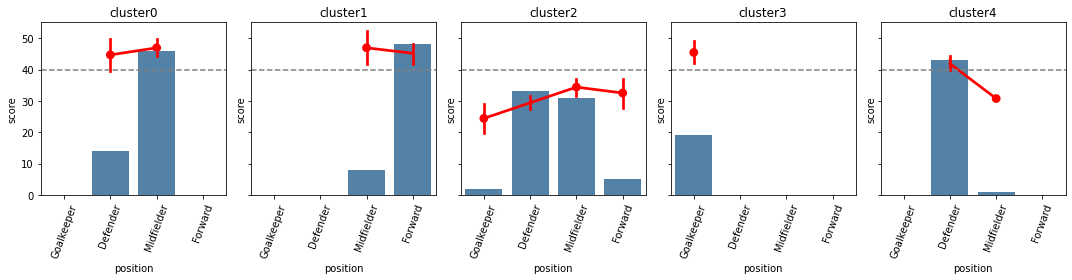

In [788]:

positions=['Goalkeeper','Defender','Midfielder','Forward']
labels=range(0,n_clusters)

n_plots=df_output['label'].nunique()
max_col=5
max_row=int(np.ceil(n_plots/max_col))

n_row=0
n_col=0
fig,ax=plt.subplots(max_row,max_col,figsize=(15,4),squeeze=False,sharey=True)
for i in range(n_plots):
    df=df_output[df_output.label==i]
    sns.countplot(data=df,x='position',ax=ax[n_row,n_col],color='steelblue',order=positions)
    sns.pointplot(data=df,x='position',y='score',ax=ax[n_row,n_col],color='red',order=positions)
    ax[n_row,n_col].axhline(40, ls='--',color='gray')
    ax[n_row,n_col].set_xticklabels(ax[n_row,n_col].get_xticklabels(),rotation=70)

    ax[n_row,n_col].set_title('cluster'+str(i))
    n_col+=1
    if(n_col==max_col):
        n_col=0
        n_row+=1
plt.tight_layout()

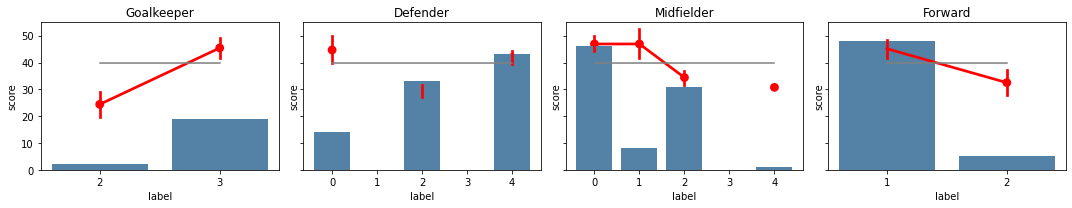

In [789]:


n_plots=df_output['label'].nunique()
max_col=4
max_row=int(np.ceil(len(positions)/max_col))

n_row=0
n_col=0
fig,ax=plt.subplots(max_row,max_col,figsize=(15,3),squeeze=False,sharey=True)
for i in positions:
    df=df_output[df_output.position==i].copy()
    sns.countplot(data=df,x='label',ax=ax[n_row,n_col],color='steelblue',order=labels)
    sns.pointplot(data=df,x='label',y='score',ax=ax[n_row,n_col],color='red',order=labels)
    sns.lineplot(x=df.label,y=np.ones(df.label.shape[0])*40,ax=ax[n_row,n_col],color='gray')

    ax[n_row,n_col].set_title(str(i))
    n_col+=1
    if(n_col==max_col):
        n_col=0
        n_row+=1
plt.tight_layout()

In [790]:
df_output['label_name']=df_output.label.map({0:'Mid',1:'Offensive',2:'low',3:'Goalkeeper',4:'Defensive'})

df_output.rename(columns={
    'dist_cluster_0':'dist_midfielder',
    'dist_cluster_1':'dist_offensive',
    'dist_cluster_2':'dist_low',
    'dist_cluster_3':'dist_goalkeeper',
    'dist_cluster_4':'dist_defensive'
},inplace=True)

dist_col_names=['dist_midfielder','dist_offensive',
    'dist_low','dist_goalkeeper','dist_defensive']

In [791]:
df_output['label_name'].value_counts()

low           71
Mid           60
Offensive     56
Defensive     44
Goalkeeper    19
Name: label_name, dtype: int64

In [792]:
cluster_stats=df_output.groupby('label_name')[stat_columns].mean()
cluster_stats

,mins_played,yellow_card,was_fouled,error_lead_to_shot,double_double,triple_double,triple_triple,poss_lost_ctrl,duel_lost,duel_won,...,effective_clearance,long_pass_own_to_opp_success,goal_assist,red_card,assist_penalty_won,error_lead_to_goal,own_goals,clearance_off_line,penalty_conceded,penalty_save
label_name,,,,,,,,,,,,,,,,,,,,,
Defensive,79.440909,0.181818,0.009091,0.036364,0.177273,0.040909,0.000000,9.072727,2.859091,3.631818,...,3.122727,4.877273,0.022727,0.013636,0.004545,0.013636,0.004545,0.004545,0.031818,0.000000
Goalkeeper,86.210526,0.063158,0.000000,0.042105,0.000000,0.000000,0.000000,11.210526,0.000000,0.000000,...,0.000000,0.000000,0.010526,0.000000,0.000000,0.021053,0.000000,0.000000,0.000000,0.021053
Mid,77.686667,0.226667,1.038333,0.010000,0.195000,0.036667,0.003333,12.760000,4.705000,5.371667,...,0.380000,0.800000,0.086667,0.006667,0.003333,0.000000,0.000000,0.006667,0.003333,0.000000
Offensive,64.589286,0.129464,1.218750,0.010714,0.032143,0.000000,0.000000,10.253571,5.315179,4.124107,...,0.000000,0.000000,0.142857,0.010714,0.010714,0.000000,0.000000,0.007143,0.003571,0.000000
low,50.966197,0.143662,0.295775,0.008451,0.115493,0.042254,0.000000,6.684507,2.628169,2.552113,...,0.552113,1.073239,0.030986,0.002817,0.000000,0.002817,0.000000,0.005634,0.002817,0.000000


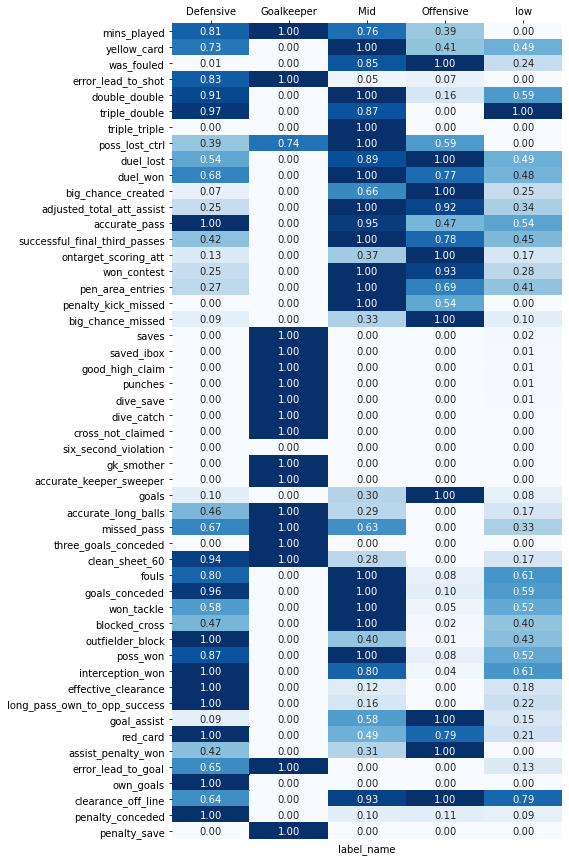

In [781]:
scaler=MinMaxScaler()
cluster_scaled=scaler.fit_transform(cluster_stats)

df_cluster_scaled=pd.DataFrame(data=cluster_scaled,columns=stat_columns,index=cluster_stats.index)

plt.figure(figsize=(7,15))
sns.heatmap(df_cluster_scaled.T,annot=True,cbar=False,fmt='.2f',cmap='Blues')
plt.gca().xaxis.set_ticks_position('top')


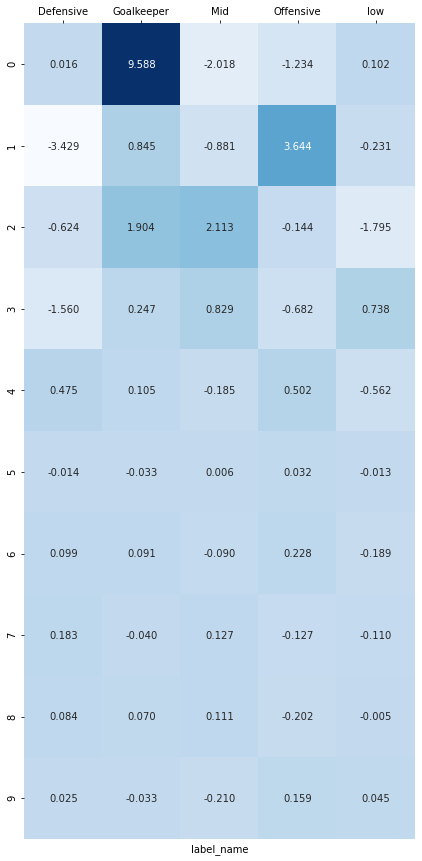

In [782]:
output_pca=df_pca.copy()
output_pca['label_name']=df_output['label_name']
cluster_pca=output_pca.groupby('label_name').mean()

plt.figure(figsize=(7,15))
sns.heatmap(cluster_pca.T,annot=True,cbar=False,fmt='.3f',cmap='Blues')
plt.gca().xaxis.set_ticks_position('top')

In [783]:
df_output.slug_club.unique()

array(['athletic-club-bilbao', 'osasuna-pamplona-irunea',
       'atletico-madrid-madrid', 'cadiz-cadiz',
       'deportivo-alaves-vitoria-gasteiz', 'elche-elche',
       'barcelona-barcelona', 'getafe-getafe-madrid', 'granada-granada',
       'levante-valencia', 'rayo-vallecano-madrid', 'real-betis-sevilla',
       'celta-de-vigo-vigo', 'mallorca-palma-de-mallorca',
       'real-madrid-madrid', 'real-sociedad-donostia-san-sebastian',
       'espanyol-barcelona', 'sevilla-sevilla-1890', 'valencia-valencia',
       'villarreal-villarreal'], dtype=object)

In [793]:
col_names=['label_name','slug_player','score','position','slug_club','mins_played','dist_midfielder','dist_offensive',
    'dist_low','dist_goalkeeper','dist_defensive']
df_output_dists=df_output[col_names].sort_values(by='label_name')
df_output_dists[df_output_dists.slug_club.isin(['real-madrid-madrid','atletico-madrid-madrid','barcelona-barcelona'])][col_names].sort_values(by='label_name')

,label_name,slug_player,score,position,slug_club,mins_played,dist_midfielder,dist_offensive,dist_low,dist_goalkeeper,dist_defensive
486,Defensive,eder-gabriel-militao,61.26,Defender,real-madrid-madrid,90.0,7.302662,10.397035,7.740451,13.100023,4.262069
464,Defensive,ferland-mendy,51.76,Defender,real-madrid-madrid,79.4,3.387552,5.733977,3.045285,10.811334,2.830689
459,Defensive,david-olatukunbo-alaba,43.38,Defender,real-madrid-madrid,72.0,6.305128,6.622333,4.271396,10.577111,3.560308
210,Defensive,gerard-pique-bernabeu,56.34,Defender,barcelona-barcelona,72.0,6.323509,9.046155,5.838914,12.564416,2.576958
83,Defensive,mario-hermoso-canseco,41.74,Defender,atletico-madrid-madrid,90.0,5.590200,7.930844,5.546699,11.506520,2.660519
201,Goalkeeper,marc-andre-ter-stegen,39.32,Goalkeeper,barcelona-barcelona,90.0,8.511592,7.535407,5.749262,5.003084,7.404143
75,Goalkeeper,jan-oblak,41.38,Goalkeeper,atletico-madrid-madrid,90.0,8.255686,7.829777,6.300240,4.234314,7.270197
481,Goalkeeper,thibaut-courtois,56.64,Goalkeeper,real-madrid-madrid,90.0,9.534941,8.542749,7.115812,4.352536,8.074872
483,Mid,toni-kroos,82.96,Midfielder,real-madrid-madrid,86.6,8.163882,9.953066,10.698535,15.497979,10.970738
80,Mid,jorge-resurreccion-merodio,43.18,Midfielder,atletico-madrid-madrid,72.0,2.839025,5.590501,3.714756,11.474624,5.276629


In [794]:
df_output_dists['min_dist']=df_output_dists[dist_col_names].apply(min,axis=1)
mask_max=df_output_dists['min_dist']>df_output_dists['min_dist'].quantile(0.95)
df_output_dists[mask_max]

,label_name,slug_player,score,position,slug_club,mins_played,dist_midfielder,dist_offensive,dist_low,dist_goalkeeper,dist_defensive,min_dist
275,Goalkeeper,luis-manuel-arantes-maximiano,43.76,Goalkeeper,granada-granada,90.0,13.083293,12.963427,12.066193,6.737774,12.420465,6.737774
615,Goalkeeper,jasper-cillessen,48.66,Goalkeeper,valencia-valencia,90.0,14.706534,14.482942,13.682660,7.429609,14.397830,7.429609
159,Goalkeeper,edgar-badia-guardiola,54.54,Goalkeeper,elche-elche,90.0,18.276181,18.173322,17.456505,10.304176,17.935286,10.304176
348,Goalkeeper,stole-dimitrievski,45.36,Goalkeeper,rayo-vallecano-madrid,72.0,13.731945,13.256451,12.279279,7.860234,13.048699,7.860234
104,Goalkeeper,jeremias-ledesma,41.20,Goalkeeper,cadiz-cadiz,90.0,17.407007,17.390916,16.700922,7.074530,16.793739,7.074530
649,Goalkeeper,geronimo-rulli,58.26,Goalkeeper,villarreal-villarreal,90.0,19.499073,19.371590,18.728129,11.696828,19.083900,11.696828
291,Mid,jose-angel-gomez-campana,50.38,Midfielder,levante-valencia,86.8,7.065403,9.472503,9.288021,14.604757,9.285458,7.065403
119,Mid,alejandro-fernandez-iglesias,45.42,Midfielder,cadiz-cadiz,77.6,7.202294,8.542917,7.739393,13.283186,7.872337,7.202294
70,Mid,geoffrey-kondogbia,55.66,Midfielder,atletico-madrid-madrid,85.6,13.589894,15.681809,14.074369,18.172998,14.190695,13.589894
483,Mid,toni-kroos,82.96,Midfielder,real-madrid-madrid,86.6,8.163882,9.953066,10.698535,15.497979,10.970738,8.163882


In [800]:
px.scatter(df_output_dists[df_output_dists.position!='Goalkeeper'],
x='dist_defensive',y='dist_offensive',
color='label_name',hover_data=['slug_club','slug_player','mins_played','position','score'],
title='Offensive and defensive similarity')

In [802]:
px.scatter(df_output_dists[df_output_dists.position!='Goalkeeper'],
x='dist_midfielder',y='dist_offensive',
color='label_name',hover_data=['slug_club','slug_player','mins_played','position','score'],
title='Midfielder and offensive similarity')

In [740]:
metric='poss_won'
df_laliga_player_scores_grouped.sort_values(by=metric,ascending=False)[['slug_club','slug_player','position','score',metric]]

,slug_club,slug_player,position,score,poss_won
136,deportivo-alaves-vitoria-gasteiz,mamadou-loum-ndiaye,Midfielder,41.60,9.0
70,atletico-madrid-madrid,geoffrey-kondogbia,Midfielder,55.66,8.6
25,athletic-club-bilbao,unai-vencedor-paris,Midfielder,45.70,8.2
575,sevilla-sevilla-1890,jules-kounde,Defender,43.72,8.2
354,rayo-vallecano-madrid,oscar-valentin-martin-luengo,Midfielder,54.88,8.0
...,...,...,...,...,...
390,celta-de-vigo-vigo,alfonso-gonzalez-martinez,Forward,0.00,0.0
170,elche-elche,john-nwankwo-donald-okeh,Midfielder,0.00,0.0
388,real-betis-sevilla,youssouf-sabaly,Defender,0.00,0.0
387,real-betis-sevilla,yassin-fekir,Midfielder,0.00,0.0


In [720]:
toni_kroos=df_laliga_player_scores_grouped[df_laliga_player_scores_grouped.slug_player=='toni-kroos']
toni_kroos.loc[483].iloc[3:]

slug_player                          toni-kroos
status.lastFiveSo5Appearances                 5
status.lastFiveSo5AverageScore            82.96
status.lastFifteenSo5Appearances             15
status.lastFifteenSo5AverageScore          78.7
status.playingStatus                    starter
position                             Midfielder
score                                     82.96
level_score                                 0.0
mins_played                                86.6
yellow_card                                 0.0
was_fouled                                  1.4
error_lead_to_shot                          0.0
double_double                               0.2
triple_double                               0.2
triple_triple                               0.0
poss_lost_ctrl                              9.8
duel_lost                                   1.6
duel_won                                    3.0
big_chance_created                          0.2
adjusted_total_att_assist               

In [811]:
df_player_stats_scaled=pd.DataFrame(index=X.index,columns=X.columns,data=X_scaled)
df_player_stats_scaled=df_player_stats_scaled.join(df_output[['slug_club','slug_player','label_name','position','score']],how='left')

In [812]:
df_laliga_players[df_laliga_players.slug_player=='julen-agirrezabala-astulez']

,name,slug_club,displayName,slug_player,status.lastFiveSo5Appearances,status.lastFiveSo5AverageScore,status.lastFifteenSo5Appearances,status.lastFifteenSo5AverageScore,status.playingStatus,lastClub.name,lastClub.activeCompetitions,allSo5Scores.nodes
431,Athletic Club Bilbao,athletic-club-bilbao,Julen Agirrezabala,julen-agirrezabala-astulez,2,49.4,2,49.4,regular,Athletic Club Bilbao,"[{'name': 'Primera División'}, {'name': 'Copa ...","[{'position': 'Goalkeeper', 'score': None, 'de..."


In [ ]:
df_laliga_player_scores_grouped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 666 entries, 0 to 665
Data columns (total 64 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   name                               666 non-null    object 
 1   slug_club                          666 non-null    object 
 2   displayName                        666 non-null    object 
 3   slug_player                        666 non-null    object 
 4   status.lastFiveSo5Appearances      666 non-null    int64  
 5   status.lastFiveSo5AverageScore     666 non-null    float64
 6   status.lastFifteenSo5Appearances   666 non-null    int64  
 7   status.lastFifteenSo5AverageScore  666 non-null    float64
 8   status.playingStatus               666 non-null    object 
 9   position                           666 non-null    object 
 10  score                              666 non-null    float64
 11  level_score                        666 non-null    float64

In [ ]:
df_laliga_players.groupby('name')['status.lastFifteenSo5AverageScore'].agg(['count','mean','std','median','max','min']).sort_values(by='mean',ascending=False)

,count,mean,std,median,max,min
name,,,,,,
Villarreal CF,34,37.505690,19.498388,40.945833,71.275000,0.0
Real Madrid CF,34,35.318331,24.893019,38.483333,78.700000,0.0
FC Barcelona,38,31.403447,22.374172,38.758333,64.081818,0.0
CA Osasuna,31,30.168897,15.863803,34.575000,55.178571,0.0
Real Betis Balompié,36,29.944485,20.160150,36.452083,57.972727,0.0
Elche CF,32,29.855118,18.299582,36.377308,53.081818,0.0
Rayo Vallecano,32,29.774691,19.390670,34.972500,59.123077,0.0
Cádiz CF,31,29.768806,16.034088,36.364286,46.266667,0.0
Club Atlético de Madrid,32,29.470085,21.632440,38.218750,59.781818,0.0


In [ ]:
df_adjusted=df_laliga_players.copy()
df_adjusted['adjusted_lastFiveSo5AverageScore']=(df_adjusted['status.lastFiveSo5AverageScore']*df_adjusted['status.lastFiveSo5Appearances'])/5
df_adjusted['adjusted_lastFifteenSo5AverageScore']=(df_adjusted['status.lastFifteenSo5AverageScore']*df_adjusted['status.lastFifteenSo5Appearances'])/15
df_adjusted['adjusted_lastFifteenSo5AverageScore']=df_adjusted['adjusted_lastFifteenSo5AverageScore'].round(2)

In [ ]:
df_adjusted[df_adjusted.name=='Villarreal CF']

,name,slug_club,displayName,slug_player,status.lastFiveSo5Appearances,status.lastFiveSo5AverageScore,status.lastFifteenSo5Appearances,status.lastFifteenSo5AverageScore,status.playingStatus,lastClub.name,lastClub.activeCompetitions,allSo5Scores.nodes,adjusted_lastFiveSo5AverageScore,adjusted_lastFifteenSo5AverageScore
243,Villarreal CF,villarreal-villarreal,Unai Emery,unai-emery-etxegoien,0,0.000000,0,0.000000,not_playing,Villarreal CF,"[{'name': 'Primera División'}, {'name': 'UEFA ...",[],0.00,0.00
244,Villarreal CF,villarreal-villarreal,Iborra,vicente-iborra-de-la-fuente,5,39.620000,7,40.114286,regular,Villarreal CF,"[{'name': 'Primera División'}, {'name': 'UEFA ...","[{'position': 'Midfielder', 'score': 74.7, 'de...",39.62,18.72
245,Villarreal CF,villarreal-villarreal,Serge Aurier,serge-aurier,1,51.400000,6,40.883333,not_playing,Villarreal CF,"[{'name': 'Primera División'}, {'name': 'UEFA ...","[{'position': 'Defender', 'score': 51.4, 'deta...",10.28,16.35
246,Villarreal CF,villarreal-villarreal,Manu Trigueros,manuel-trigueros-munoz,5,52.260000,13,46.007692,starter,Villarreal CF,"[{'name': 'Primera División'}, {'name': 'UEFA ...","[{'position': 'Midfielder', 'score': 88.2, 'de...",52.26,39.87
247,Villarreal CF,villarreal-villarreal,Aïssa Mandi,aissa-mandi,1,98.700000,3,53.766667,not_playing,Villarreal CF,"[{'name': 'Primera División'}, {'name': 'UEFA ...","[{'position': 'Defender', 'score': None, 'deta...",19.74,10.75
248,Villarreal CF,villarreal-villarreal,Paco Alcácer,francisco-alcacer-garcia,1,24.200000,5,37.080000,not_playing,Villarreal CF,"[{'name': 'Primera División'}, {'name': 'UEFA ...","[{'position': 'Forward', 'score': None, 'detai...",4.84,12.36
249,Villarreal CF,villarreal-villarreal,Rubén Peña,ruben-pena-jimenez,1,24.900000,2,36.500000,not_playing,Villarreal CF,"[{'name': 'Primera División'}, {'name': 'UEFA ...","[{'position': 'Midfielder', 'score': None, 'de...",4.98,4.87
250,Villarreal CF,villarreal-villarreal,Boulaye Dia,boulaye-dia,5,53.520000,12,43.416667,starter,Villarreal CF,"[{'name': 'Primera División'}, {'name': 'UEFA ...","[{'position': 'Forward', 'score': 84.3, 'detai...",53.52,34.73
251,Villarreal CF,villarreal-villarreal,Gerard Moreno,gerard-moreno-balaguero,5,85.480000,8,71.275000,starter,Villarreal CF,"[{'name': 'Primera División'}, {'name': 'UEFA ...","[{'position': 'Forward', 'score': 92.7, 'detai...",85.48,38.01
252,Villarreal CF,villarreal-villarreal,Filip Jörgensen,filip-jorgensen,0,0.000000,0,0.000000,not_playing,Villarreal CF Under 19,"[{'name': 'División de Honor Juvenil'}, {'name...","[{'position': 'Goalkeeper', 'score': None, 'de...",0.00,0.00


In [ ]:
px.scatter(df_adjusted,x='adjusted_lastFifteenSo5AverageScore',y='adjusted_lastFiveSo5AverageScore',
            hover_data=['name','displayName'],color='name',range_x=(0,100),range_y=(0,100))